## **Agricultural drought in central South America**

- use 1980-2010 to calibrate - this period exists in ERA5, CPC, MSWEP
- under the [standard drought classification](https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx) we're interested in moderate droughts (threshold 0.8). Classify as a drought month if below -0.8, drought ends when > -0.8 (NOT over zero) for two or more months.
- see Reddy & Ganguli, application of copulas for derivation of drought severity–duration–frequency curves


Still to check/do:
- for SPI3, should drought severity be computed by summing all monthly values, or three-monthly?
- filtering of arid regions needed (exclude >0.25% zero values; prcptot/pet <= 0.05)

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

from xclim.indices.stats import fit
from xclim.indices.run_length import rle

import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

import warnings
warnings.filterwarnings("ignore", message = "overflow encountered in exp.+")                           # warning about change to Cartopy plotting defaults

### **Data pre-processing**

#### **Trim ERA5 to S America land surface**

In [ ]:
# trim data & save as monthly
lsm = xr.open_dataset("../../Data/era5/era5_lsm_025.nc").squeeze(drop = True).lsm.sel(latitude = slice(-10,-50), longitude = slice(280,320)).rename(longitude = "lon", latitude = "lat")

decode_times(xr.open_dataset("data/era5_tp_-80--40E_-50--10N_su.nc", decode_times = False)).tp.rename("precip").where(lsm >= 0.5).to_netcdf("data/era5_precip_monthly.nc")
decode_times(xr.open_dataset("data/era5_evap_-80--40E_-50--10N_su.nc", decode_times = False)).evap.rename("pet").where(lsm >= 0.5).to_netcdf("data/era5_pet_monthly.nc")
decode_times(xr.open_dataset("data/era5_t2m_-80--40E_-50--10N_su.nc", decode_times = False)).t2m.rename("tas").where(lsm >= 0.5).to_netcdf("data/era5_tas_monthly.nc")

#### **CPC monthly temperature & PET**

In [2]:
from xclim.indices import potential_evapotranspiration

# compute mean temps, save for later plotting
tmin = xr.open_mfdataset("../../Data/cpc/tmin.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmin
tmax = xr.open_mfdataset("../../Data/cpc/tmax.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmax
tas = (tmax + tmin) / 2
tas.resample(time = "MS").mean().rename("tas").to_netcdf("data/cpc_tas_monthly.nc")

# compute PET using Hargreaves - McGuinness-Bordne has an issue in Dec/Jan
pet = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "HG85").rename("pet").resample(time = "MS").mean(), "mm/day")
pet.to_netcdf("data/cpc_pet_monthly.nc")

#### **Flatten data for processing in R**

In [59]:
# flatten data for processing in R
for ens in ["era5", "cpc"]:

    # precipitation
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pr = pr.where(np.isnan(pr).sum("time") < 100)
    pr.stack(xy = ["lat", "lon"]).to_pandas().to_csv("data/"+ens+"_pr_monthly.csv")
    
    # effective precipitation
    pet = xr.open_dataset("data/"+ens+"_pet_monthly.nc").pet
    eff_pr = (pr - pet).where(np.isnan(pr).sum("time") < 100)
    eff_pr.stack(xy = ["lat", "lon"]).to_pandas().to_csv("data/"+ens+"_eff-pr_monthly.csv")


### **Compute drought indices**

---
#### **SPI**

In [5]:
for ens in ["era5", "cpc"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pr_n = pr.rolling(time = 3, center = False).mean(keep_attrs = False)
    pr_n = pr_n.where(np.isnan(pr_n).sum("time") < 100)                          # skip any cells with high proportion of missing data

    spi_monthly = []
    # fit each calendar month in turn
    for i in range(12):
        
        # select current calendar month
        pr_m = pr_n.sel(time = pr_n.time.dt.month == i+1)
        
        # estimate parameters over calibration period
        pr_cal = pr_m.sel(time = slice("1980", "2010")).copy()
        pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")
        
        # normalise all values using fitted parameters
        spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spi_finite = xr.concat([spi_m.where(~np.isinf(spi_m)), 
                                xr.ones_like(spi_m).where(spi_m == np.inf) * spi_m.where(spi_m < np.inf).max("time"),
                                xr.ones_like(spi_m).where(spi_m == -np.inf) * spi_m.where(spi_m > -np.inf).min("time")], "new").sum("new").copy()
        
        # append to list of monthly SPI for concatenation
        spi_monthly.append(spi_finite)
        
    # concatenate monthly fitted values, reorder & relabel
    spi = xr.concat(spi_monthly, "time").sortby("time").rename("spi").assign_attrs(long_name = "SPI_3", notes = "Calibrated against 1980-2010")
    spi = spi.where(~np.isnan(pr_n)).dropna("time", "all")
    
    # save to netcdf
    spi.to_netcdf("data/"+ens+"_spi3_monthly.nc")

---
#### **SPEI**

This method replicates the fitting approach using in R (originally used to compute the SPI/SPEI).  
The PWM-estimated parameters fitted by lmoments3/xclim are based on a different parametrisation to that used in scipy: the CDF used here is taken from Hosking (1997):
\begin{align}
F(x) = \left(1+e^{-y}\right)^{-1}, &&\text{with}&& y = \left\lbrace 
    \begin{matrix} 
        -\log\left(1- \frac{\kappa(x-\xi)}{\alpha}\right) \big/ \kappa, && \kappa \neq 0 \\
        \frac{(x-\xi)}{\alpha}, && \kappa = 0
    \end{matrix} \right.
\end{align}

Note that $y$ is not defined for $\frac{\kappa(x-\xi)}{\alpha} >= 1$: where this occurs (indicating precipitation exceeding that possible under the calibration distribution), set $y = -log(0.00001) / k$

Where the CDF is found to be either 0 or 1, the normalisation step fails: the resulting infinite values are replaced with the max/min of the finite values, as appropriate.

In [4]:
# CDF of generalised logistic function used with PWM parametrisation (replicates that used in R)
def hosking_cdf(x, k, loc, scale):
    
    x_scaled = (x-loc) / scale
    
    if k == 0:
        y = x_scaled
    else:
        # if scaled value is greater than 1, replace with 0.99999 (otherwise log is NA):
        # this occurs when observed value falls above range of calibration distribution
        x_scaled = k*x_scaled
        x_scaled[x_scaled >= 1] = 0.99999
        y = -np.log(1 - x_scaled) / k
        
    Fx = 1/(1+np.exp(-y))
            
    return Fx

In [5]:
for ens in ["era5", "cpc"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pet = xr.open_dataset("data/"+ens+"_pet_monthly.nc").pet
    eff_pr = (pr - pet).where(np.isnan(pr).sum("time") < 100)              # skip any cells with high proportion of missing data
    
    epr_n = eff_pr.rolling(time = 3, center = False).mean(keep_attrs = False)

    spei_monthly = []
    for i in range(12):
        
        # select current calendar month
        epr_m = epr_n.sel(time = epr_n.time.dt.month == i+1)
        
        # estimate parameters over calibration period
        epr_cal = epr_m.sel(time = slice("1980", "2010")).copy()
        
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])
        
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(hosking_cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        
        spei_monthly.append(spei_finite)
        
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei").assign_attrs(long_name = "SPEI_3", notes = "Calibrated against 1980-2010")
    spei = spei.where(~np.isnan(epr_n)).dropna("time", "all")
    
    # save to netcdf
    spei.to_netcdf("data/"+ens+"_spei3_monthly.nc")

/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/249573

---
#### **Drought severity & duration**
Droughts classified if moderate or worse per the US drought monitor index - begins in the month when the SPI falls below -0.8, ends when it returns above this level for at least 2 consecutive months

In [31]:
from xclim.indices.run_length import _cumsum_reset_on_zero as run_cumsum

for ens in ["era5", "cpc"]:
    for varnm in ["spi3", "spei3"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+".nc")[re.sub("3", "", varnm)]
        
        # identify drought months (1 if in drought, 0 otherwise)
        idx_lo = xr.ones_like(da).where(rle(da <= -0.8) > 0)      # indicator for start of drought
        idx_pos = xr.zeros_like(da).where(rle(da > -0.8) > 1)     # indicator for start of non-drought period
        drought_months = xr.concat([idx_lo, idx_pos], "new").max("new").ffill("time").rename("drought_months")
        drought_months.to_netcdf("data/"+ens+"_"+varnm+"-drought-months.nc")

        drought_length = run_cumsum(drought_months.where(drought_months == 1, 0)).where(~np.isnan(da))
        drought_length.rename("drought_duration").assign_attrs(long_name = "Drought duration", units = "months").to_netcdf("data/"+ens+"_"+varnm+"-drought-duration.nc")
        
        drought_severity = run_cumsum(da.where(drought_months == 1, 0)).where(~np.isnan(da))
        drought_severity.rename("drought_severity").assign_attrs(long_name = "Drought severity").to_netcdf("data/"+ens+"_"+varnm+"-drought-severity.nc")
        
        # could also add drought intensity if useful - but this may take some time, as no inbuilt method in xclim

Text(0.5, 1.0, 'Drought severity')

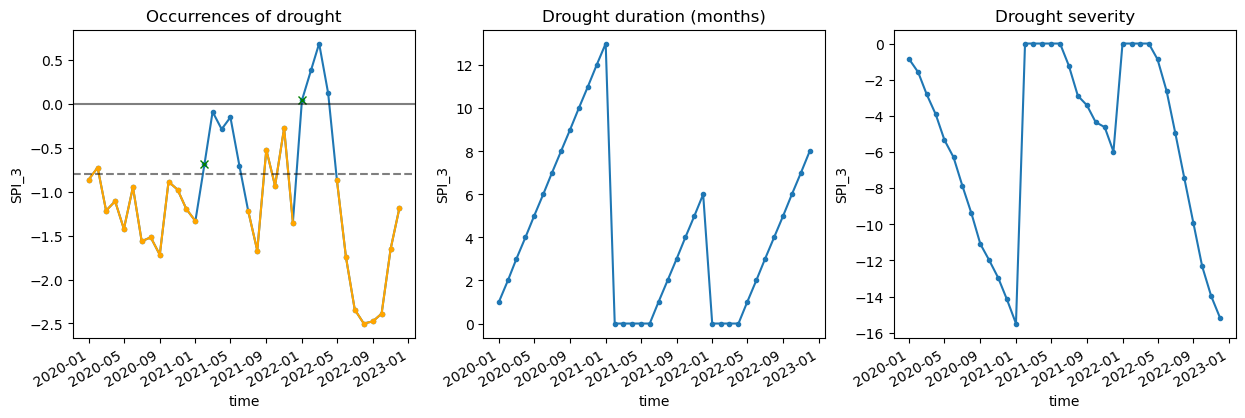

In [30]:
# time series plots for a single cell, to confirm that the calculation works

latlon = get_latlon("Buenos Aires, AR").values()
da = wrap_lon(xr.open_dataset("data/era5_spi3_monthly.nc").spi.rename(lat = "latitude", lon = "longitude").sel(time = slice("2020", None)))

fig, axs = plt.subplots(ncols = 3, dpi = 100, figsize = (15,4))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts = nearest_px(*latlon, da)
ts_lo = xr.ones_like(ts).where(rle(ts <= -0.8) > 0)                    # indicator for start of drought
ts_pos = xr.zeros_like(ts).where(rle(ts > -0.8) > 1)                   # indicator for start of non-drought
dm = xr.concat([ts_lo, ts_pos], "new").max("new").ffill("time")         # indicator for months during drought

ts.plot(ax = axs[0], marker = ".")
ts.where(ts_pos == 0).plot(ax = axs[0], color = "green", marker = "x")
ts.where(dm == 1).plot(ax = axs[0], color = "orange", marker = ".")

[axs[0].axhline(x, color = "k", ls = "--", alpha = 0.5) for x in [-0.8]]
[axs[0].axhline(x, color = "k", alpha = 0.5) for x in [0]]
axs[0].set_title("Occurrences of drought")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

run_cumsum(dm.where(dm == 1, 0)).plot(ax = axs[1], marker = ".")
axs[1].set_title("Drought duration (months)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

run_cumsum(ts.where(dm == 1, 0)).plot(ax = axs[2], marker = ".")
axs[2].set_title("Drought severity")

---
### **Monthly maps of last three years**

#### **Precipitation**

In [15]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_precip_monthly.nc").sel(time = slice("2020-07", None)).precip
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 25, cmap = 'YlGnBu')
        xr.ones_like(da).where(da == 0).isel(time = i).plot(ax = ax, add_colorbar = False, cmap = "Oranges_r", vmin = 0, vmax = 1)      # overlay zero precip as white regions - reverse cmap to show in orange
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Daily precipitation rate (mm/day)", extend = "max")
    plt.suptitle(ens.upper()+" - mean monthly precipitation", fontweight = "bold")

    plt.savefig("fig/"+ens+"_pr_monthly.png"); plt.close()

#### **Temperature**

In [249]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_tas_monthly.nc").sel(time = slice("2020-07", None)).tas
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmax = 30, vmin = -10, cmap = "RdBu_r")
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Temperature (degC)", extend = "both")
    plt.suptitle(ens.upper()+" - monthly mean temperatures", fontweight = "bold")

    plt.savefig("fig/"+ens+"_tas_monthly.png"); plt.close()

#### **PET**

In [250]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_pet_monthly.nc").sel(time = slice("2020-07", None)).pet
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 6, cmap = "viridis")
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "PET (mm/day)", extend = "max")
    plt.suptitle(ens.upper()+" - mean monthly PET rate (mm/day)", fontweight = "bold")

    plt.savefig("fig/"+ens+"_pet_monthly.png"); plt.close()

#### **Drought indices**

In [16]:
for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3_monthly.nc").sel(time = slice("2020-07", None))[varnm]
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = -4, vmax = 4, cmap = "BrBG")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        if varnm == "spi":
            plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPI_3", extend = "both")
            plt.suptitle(ens.upper()+" - 3-month standardised precipitation index", fontweight = "bold")
        else:
            plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPEI_3", extend = "both")
            plt.suptitle(ens.upper()+" - 3-month standardised precipitation-evapotranspiration index", fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3_monthly.png"); plt.close()

#### **Drought classification**

In [238]:
drought_bins = [-np.inf, -2, -1.55, -1.25, -.75, -.5]

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow'])
cmap.set_over('honeydew')
bounds = np.arange(0.5,6.5,1)

for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3_monthly.nc").sel(time = slice("2020-07", None))[varnm]
        da = xr.apply_ufunc(np.digitize, da, kwargs={'bins': bins}).where(~np.isnan(da))
        # da = da.where(da < 6)
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, cmap = cmap, norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N))
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
        cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
        
        plt.suptitle(ens.upper()+" - drought classifications using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-classification_monthly.png"); plt.close()

#### **Drought severity**

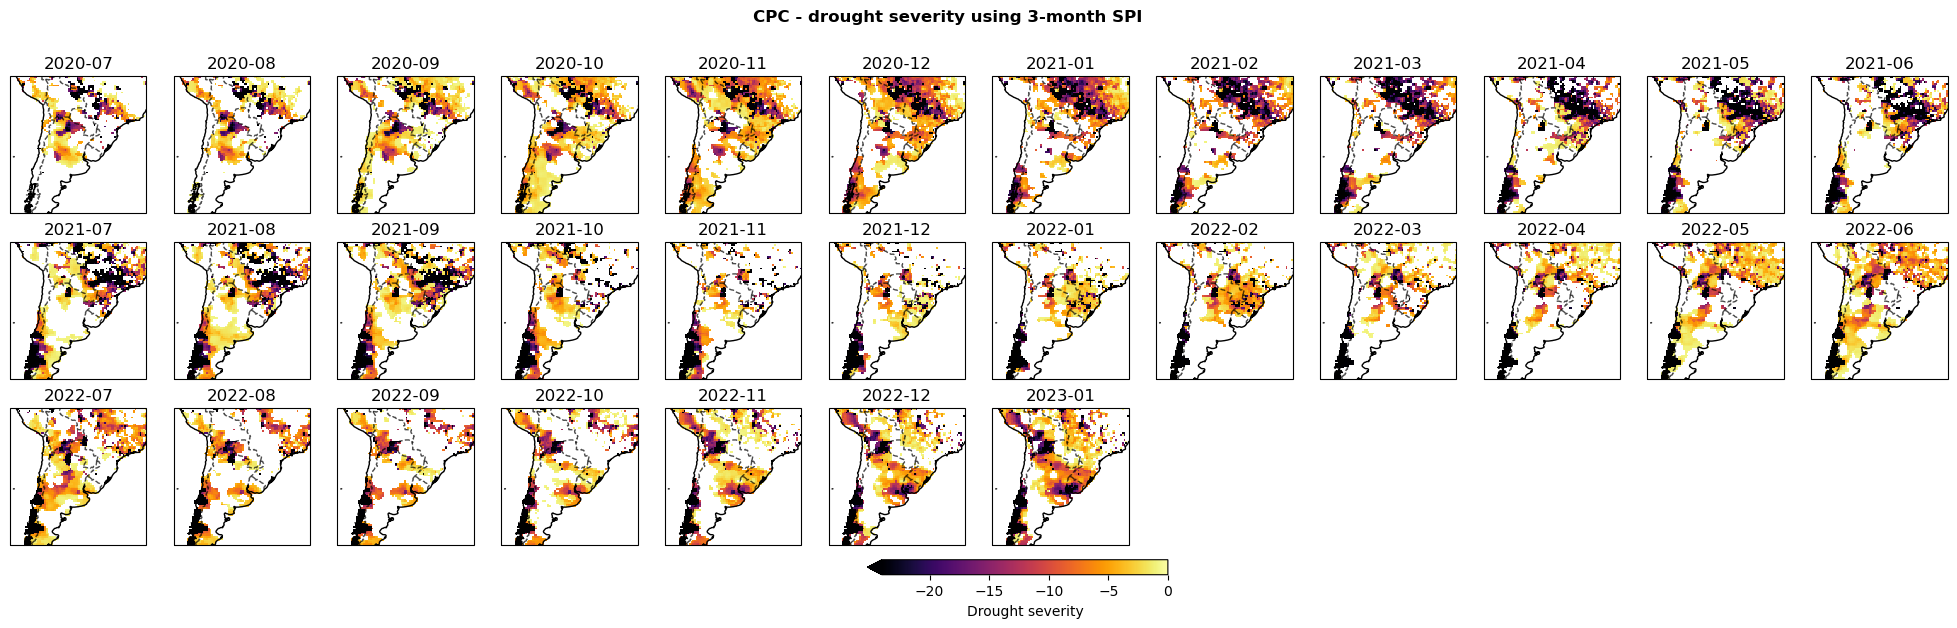

In [19]:
for ens in ["cpc", "era5"][:1]:
    for varnm in ["spi", "spei"][:1]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3-drought-severity.nc").sel(time = slice("2020-07", None)).drought_severity
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).where(da.isel(time = i) < 0).plot(ax = ax, add_colorbar = False, vmax = 0, vmin = -50, cmap = "inferno")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Drought severity", extend = "min")
        plt.suptitle(ens.upper()+" - drought severity using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-severity_monthly.png"); plt.close()

#### **Drought duration**

In [239]:
for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3-drought-duration.nc").sel(time = slice("2020-07", None)).drought_duration
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).where(da.isel(time = i) > 0).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 12, cmap = "Oranges")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Drought duration (months)", extend = "max")
        plt.suptitle(ens.upper()+" - drought duration using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-duration_monthly.png"); plt.close()

---
### **Compare R fitting vs python**

In [113]:
# load values fitted using script above
da_py = xr.open_dataset("data/cpc_spi3_monthly.nc").spi

# load & reshape values fitted using R SPEI package
df = pd.read_csv("data/cpc_spi3_rfitted.csv", index_col = "time").dropna(axis = 0, how = "all")
da_r = xr.DataArray(data = np.array(df).reshape(da_py.transpose("time", ...).shape),
                    dims = {"time" : da_py.time, "lat" : da_py.lat, "lon" : da_py.lon},
                    coords = {"time" : da_py.time, "lat" : da_py.lat, "lon" : da_py.lon})

# compare
da = (da_py - da_r).sel(time = slice("2020", None))

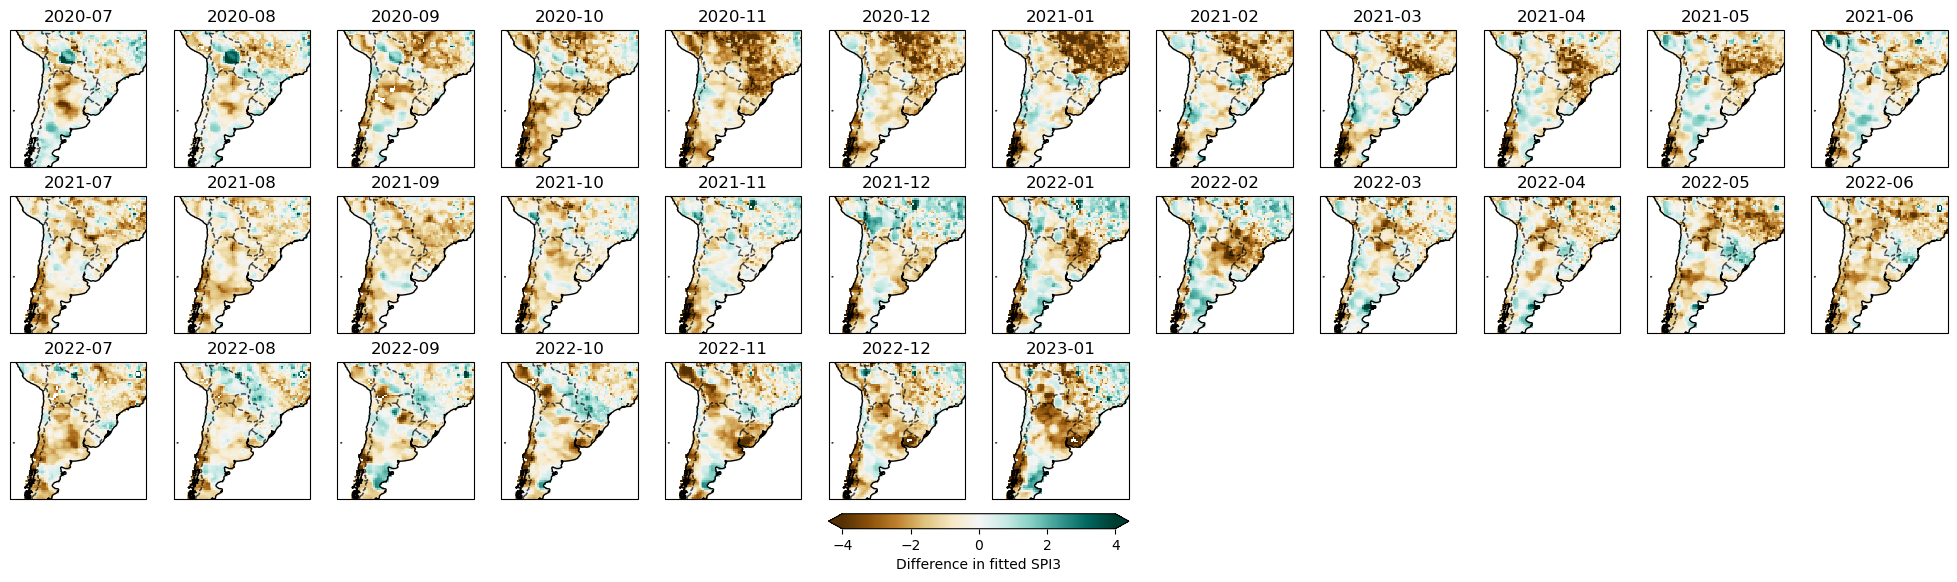

In [116]:
da = da_r.sel(time = slice("2020-07", None))

nr = int(np.ceil(len(da.time) / 12))
fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
for ax in fig.axes[len(da.time):]: ax.set_axis_off()

for i in range(len(da.time)):
    
    ax = fig.axes[i]
    cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, cmap = "BrBG", vmin = -4, vmax = 4)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
    ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Difference in fitted SPI3", extend = "both")

# Atacama desert very different, probably due to presence of large number of zeros in the data. Ditto scattered cells in Brazil.
# slightly larger differences in Jan/Feb (again, this is the dry season, so probably unsurprising)